In [22]:
from sklearn.metrics import roc_curve, auc
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from main import *
from preprocess import get_testdata
import numpy as np
import pandas as pd
import torch.nn as nn 
import torch
from itertools import chain
import matplotlib.pyplot as plt
from PIL import Image
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
train = np.load("data/train.npy")
train_label = np.load("data/train_label.npy")

In [76]:
train_loss = [0.006863, 0.006548, 0.006472, 0.006371, 0.006442, 0.006292,  0.006299,  0.006300, 0.006243, 0.006251, 0.00613]
val_acc = [0, 0.3592, 0.3748, 0.4083, 0.3948, 0.3125, 0.3747, 0.3447, 0.3456,  0.3465, 0.3466, 0.3475]

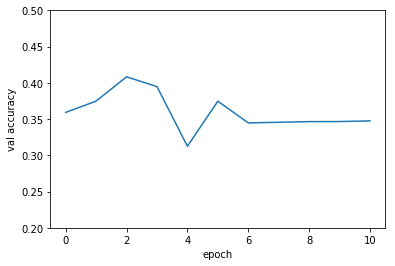

In [85]:
plt.ylim(top = 0.5)
plt.ylim(bottom = 0.2)
plt.xlabel("epoch")
plt.ylabel("val accuracy")
plt.plot(np.arange(len(val_acc)), val_acc)

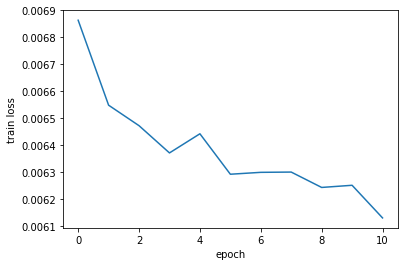

In [86]:
# plt.ylim(top = 0.5)
# plt.ylim(bottom = 0.2)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.plot(np.arange(len(train_loss)), train_loss)

In [2]:
# plot downsampled data:
data = np.load("data/train.npy")

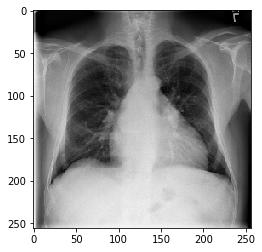

In [14]:
image = np.asarray(Image.open("data/images1/00000001_000.png").convert("L"))
plt.imshow(image, cmap="gray")
plt.imshow(data[0], cmap='gray')

# Try testing and auc

In [2]:
net = torch.load("saved_models/best.pt", map_location="cpu")

/Users/celsius/miniconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/celsius/miniconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/celsius/miniconda3/envs/torch/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ELU' has changed. you can retriev

In [5]:
test_set = get_testdata(batch_size=16, num_workers=4, num_sample = 1000)

In [6]:
print(len(test_set))
scores = []
with torch.no_grad():
    for batch_id, (batch_data, batch_label) in tqdm(enumerate(test_set)):
        out = net(batch_data)
        scores.append(out.detach().cpu().numpy())

63


63it [01:16,  1.06s/it]


In [14]:
scores = np.concatenate(scores, axis = 0)

In [16]:
labels = []
for batch_id, (batch_data, batch_label) in enumerate(test_set):
    labels.append(batch_label)

In [19]:
labels = np.concatenate(labels, axis = 0)

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, disease in enumerate(OHE_MAPPING):
    fpr[disease], tpr[disease], _ = roc_curve(labels[:, i], scores[:, i])
    roc_auc[disease] = auc(fpr[disease], tpr[disease])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

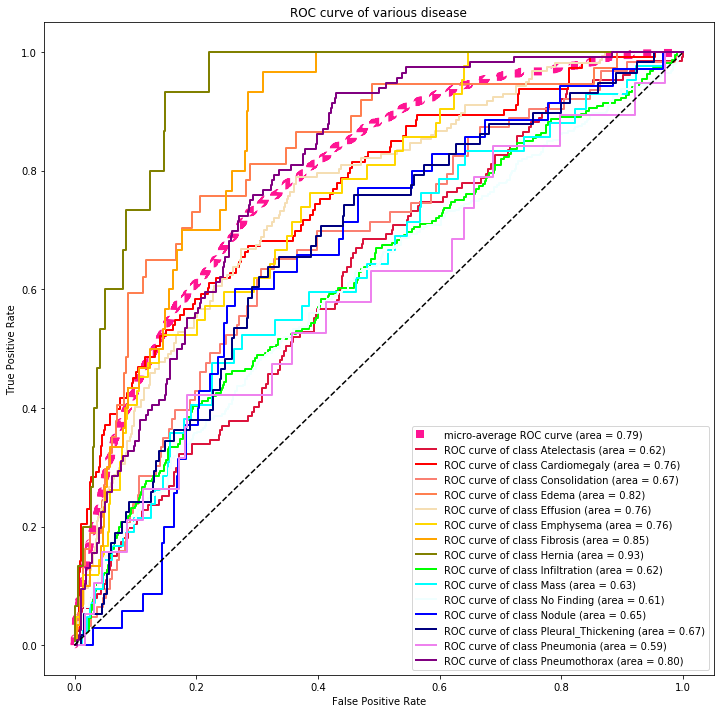

In [40]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=8)
colors = ["crimson", "red", "salmon", "coral", "wheat", "gold", "orange", "olive", "lime", "aqua", "azure", "blue", "navy", "violet", "purple"]
for dis, color in zip(OHE_MAPPING, colors):
    plt.plot(fpr[dis], tpr[dis], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(dis, roc_auc[dis]))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve of various disease')
ax.legend(loc="lower right")